In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [11]:
x = np.load('distribution.npy')

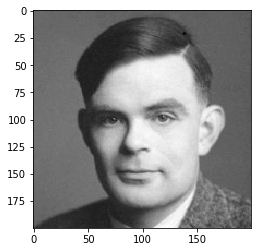

In [12]:
plt.imshow(x, cmap='gray')

In [13]:
x_flat = x.flatten()
nrof_samples = 100000
xsamp = np.random.choice(x_flat.shape[0], size=(nrof_samples,), p=x_flat)
xu = np.unravel_index(xsamp, shape=x.shape)
X = np.stack(xu).T

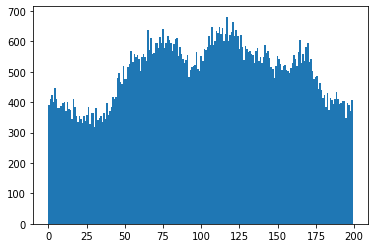

In [14]:
_ = plt.hist(X[:,0], bins=200, range=[0,199])

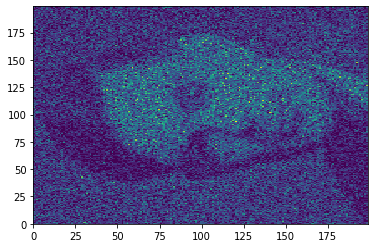

In [15]:
_ = plt.hist2d(X[:,0], X[:,1], bins=200, range=np.array([[0,199], [0,199]]))

In [16]:
nrof_test_samples = int(nrof_samples*0.2)
X_train = X[:-nrof_test_samples,:]
X_test = X[-nrof_test_samples:,:]
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (80000, 2)
X_test:  (20000, 2)


In [17]:
def log2(x):
    return tf.log(x) / tf.log(2.0)

def dense(x, nrof_units, activation=None, training=True, use_batch_norm=False):
    x = tf.compat.v1.layers.Dense(units=nrof_units, kernel_initializer=tf.initializers.glorot_normal)(x)
    if use_batch_norm:
        x = tf.compat.v1.layers.BatchNormalization()(x, training=training)
    x = x if activation is None else activation(x)
    return x

def mlp(x, nrof_units, activation, nrof_layers=1, training=True):
    for _ in range(nrof_layers):
        x = dense(x, nrof_units=nrof_units, activation=activation, training=training)
    x = dense(x, nrof_units=nrof_units, activation=None, training=training)
    return x

def create_model(x, nrof_dims=200):
    dbg = dict()
    x1 = x[:,0]
    theta1 = tf.get_variable(name='theta1', shape=(nrof_dims,), dtype=tf.float32, initializer=tf.zeros_initializer, trainable=True)
    th1 = tf.gather(theta1, x1)
    px1 = tf.math.exp(th1) / tf.reduce_sum(tf.math.exp(theta1)) #p(x1)
    dbg['px1'] = px1
    dbg['x1'] = x1
    dbg['th1'] = th1
    dbg['theta1'] = theta1
    dbg['theta1_norm'] = tf.math.exp(theta1) / tf.reduce_sum(tf.math.exp(theta1))
    
    x2 = x[:,1]
    dbg['x2'] = x2
    d2 = mlp(tf.one_hot(x1, nrof_dims), nrof_units=nrof_dims, activation=tf.nn.relu, nrof_layers=2)
    dbg['d2'] = d2
    
    th2 = tf.gather(d2, tf.expand_dims(x2, axis=1), batch_dims=1)
    dbg['th2'] = th2
    px2_x1 = (tf.math.exp(th2) / tf.reduce_sum(tf.math.exp(d2)))[:,0]  # p(x2|x1)
    dbg['px2'] = px2_x1
    dbg['theta2_norm'] = tf.math.exp(d2) / tf.reduce_sum(tf.math.exp(d2))  # p(x2|x1)
    px = px1 * px2_x1
    dbg['px'] = px
    loss = -tf.reduce_mean(log2(px1)+log2(px2_x1))
    dbg['log_px1'] = tf.reduce_mean(log2(px1))
    dbg['log_px2'] = tf.reduce_mean(log2(px2_x1))
    dbg['log_px'] = tf.reduce_mean(log2(px1)+log2(px2_x1))
    return loss, dbg


In [18]:
tf.reset_default_graph()
with tf.Graph().as_default():

    batch_size = 100
    x_ph = tf.placeholder(tf.int32, shape=(None,2))
    loss, dbg = create_model(x_ph, nrof_dims=200)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())

    nrof_train_batches = int(np.floor(X_train.shape[0] / batch_size))
    nrof_epochs = 50
    train_loss_list = []
    dbg_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            x_batch = X_train[i*batch_size:(i+1)*batch_size]
            _, loss_, dbg_ = sess.run([train_op, loss, dbg], feed_dict={x_ph: x_batch})
            train_loss_list += [ loss_ ]
            if i==0:
                dbg_list += [ dbg_ ]

        print('train epoch: %d  loss: %.3f' % (epoch, loss_/2))
    test_loss_ = sess.run(loss, feed_dict={x_ph: X_test})
    print('Test NLL: %.3f bits/dim' % (test_loss_/2))


train epoch: 1  loss: 10.956
train epoch: 2  loss: 10.953
train epoch: 3  loss: 10.952
train epoch: 4  loss: 10.951
train epoch: 5  loss: 10.949
train epoch: 6  loss: 10.948
train epoch: 7  loss: 10.946
train epoch: 8  loss: 10.944
train epoch: 9  loss: 10.941
train epoch: 10  loss: 10.938
train epoch: 11  loss: 10.936
train epoch: 12  loss: 10.932
train epoch: 13  loss: 10.929
train epoch: 14  loss: 10.926
train epoch: 15  loss: 10.923
train epoch: 16  loss: 10.920
train epoch: 17  loss: 10.917
train epoch: 18  loss: 10.914
train epoch: 19  loss: 10.911
train epoch: 20  loss: 10.909
train epoch: 21  loss: 10.906
train epoch: 22  loss: 10.903
train epoch: 23  loss: 10.901
train epoch: 24  loss: 10.899
train epoch: 25  loss: 10.896
train epoch: 26  loss: 10.894
train epoch: 27  loss: 10.891
train epoch: 28  loss: 10.889
train epoch: 29  loss: 10.887
train epoch: 30  loss: 10.885
train epoch: 31  loss: 10.883
train epoch: 32  loss: 10.881
train epoch: 33  loss: 10.878
train epoch: 34  lo

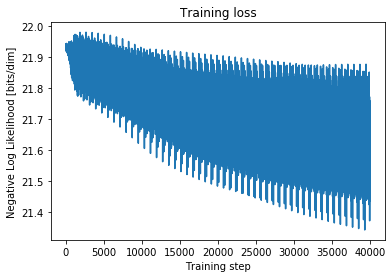

In [19]:
plt.plot(train_loss_list)
plt.title('Training loss')
plt.xlabel('Training step')
_ = plt.ylabel('Negative Log Likelihood [bits/dim]')

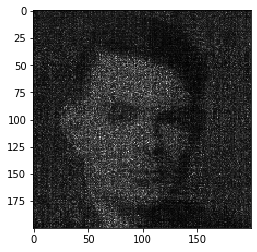

In [20]:
x1, x2 = np.meshgrid(np.arange(200), np.arange(200))
X_mesh = np.vstack([x1.flatten(),x2.flatten()]).T
px = np.zeros(shape=(200,200), dtype=np.float32)
nrof_batches = X_mesh.shape[0] // 200
dbg_ = sess.run(dbg, feed_dict={x_ph: X_mesh})
px = dbg_['px']
_ = plt.imshow(np.rot90(np.reshape(px, (200,200)), k=3), cmap='gray')

In [21]:
def dense_masked(x, nrof_units, mask, activation=None):
    nrof_inputs = x.get_shape()[1]
    kernel = tf.get_variable('kernel', shape=(nrof_inputs, nrof_units), dtype=tf.float32, 
        initializer=tf.initializers.glorot_normal, trainable=True)
    bias = tf.get_variable('bias', shape=(nrof_units,), dtype=tf.float32, 
        initializer=tf.initializers.zeros, trainable=True)
    y = tf.tensordot(x, kernel*mask.T, 1) + bias
    y = activation(y) if activation else y
    return y
    
def get_masks(nrof_units, nrof_layers, nrof_dims, nrof_bins):
    # Based on code from Andrej Karpathy
    #  https://github.com/karpathy/pytorch-made/blob/master/made.py
    seed = 666
    np.random.seed(seed)        
        
    m = []
    m += [ np.repeat(np.arange(nrof_dims), nrof_bins) ]
    for i in range(nrof_layers):
        m += [ np.random.randint((m[-1]).min(), nrof_dims, [nrof_units]) ]

    mask = []
    for i in range(nrof_layers):
        mask += [ m[i+1][:,None] >= m[i][None,:] ]

    mask += [ m[0][:,None] > m[-1][None,:] ]
    return mask
    
def log2(x):
    return tf.log(x) / tf.log(2.0)

def made(x, nrof_units, nrof_layers, nrof_dims, nrof_bins):
    x = tf.cast(x, tf.float32)
    masks = get_masks(nrof_units, nrof_layers, nrof_dims, nrof_bins)
    hidden = [nrof_units]*nrof_layers+[nrof_dims*nrof_bins]
    for i, h in enumerate(hidden):
        with tf.compat.v1.variable_scope('made_%d' % i):
            activation = tf.nn.relu if i<nrof_layers else None
            x = dense_masked(x, h, masks[i], activation=activation)
    return x


In [22]:
tf.reset_default_graph()
with tf.Graph().as_default():

    batch_size = 100
    nrof_units=200
    nrof_layers=2
    nrof_dims=2
    nrof_bins=200
    x_ph = tf.placeholder(tf.int32, shape=(None, nrof_dims))
    x_onehot = tf.reshape(tf.one_hot(x_ph, nrof_bins), (-1, nrof_dims*nrof_bins))
    y = made(x_onehot, nrof_units=nrof_units, nrof_layers=nrof_layers,
             nrof_dims=nrof_dims, nrof_bins=nrof_bins)
    d = tf.nn.softmax(tf.reshape(y, (-1, nrof_dims, nrof_bins)), axis=-1)
    dx1, dx2 = tf.unstack(d, num=None, axis=1)
    x1, x2 = tf.unstack(x_ph, num=None, axis=1)
    px1 = tf.gather(dx1, tf.expand_dims(x1, axis=1), batch_dims=1)
    px2 = tf.gather(dx2, tf.expand_dims(x2, axis=1), batch_dims=1)
    px = px1 * px2
    
    loss = -tf.reduce_mean(log2(px1)+log2(px2), axis=0)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())

    nrof_train_batches = int(np.floor(X_train.shape[0] / batch_size))
    nrof_epochs = 50
    train_loss_list = []
    dbg_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            x_batch = X_train[i*batch_size:(i+1)*batch_size]
            _, loss_ = sess.run([train_op, loss], feed_dict={x_ph: x_batch})
            train_loss_list += [ loss_ ]
        
        if epoch % 5 == 0:
            print('train epoch: %d  loss: %.3f' % (epoch, loss_/2))
    test_loss_ = sess.run(loss, feed_dict={x_ph: X_test})
    print('Test NLL: %.3f bits/dim' % (test_loss_/2))


train epoch: 5  loss: 7.625
train epoch: 10  loss: 7.624
train epoch: 15  loss: 7.618
train epoch: 20  loss: 7.609
train epoch: 25  loss: 7.601
train epoch: 30  loss: 7.593
train epoch: 35  loss: 7.586
train epoch: 40  loss: 7.579
train epoch: 45  loss: 7.572
train epoch: 50  loss: 7.565
Test NLL: 7.633 bits/dim


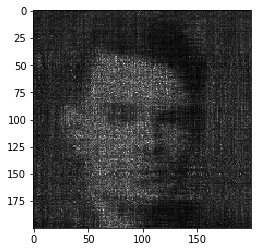

In [23]:
x1, x2 = np.meshgrid(np.arange(200), np.arange(200))
X_mesh = np.vstack([x1.flatten(),x2.flatten()]).T
px_ = sess.run(px, feed_dict={x_ph: X_mesh})
_ = plt.imshow(np.rot90(np.reshape(px_, (200,200)), k=3), cmap='gray')